In [1]:
from DataProcessing import LUNA
%matplotlib inline

import dicom as dc
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import glob
import pandas as pd
import xml
from xml.etree import ElementTree
from shapely.geometry import Polygon
from shapely.geometry import Point

luna = LUNA()

Training Data found: 649
Evaluation Data found: 649
XML Training Data found: 6
XML Evaluation Data found: 6


In [18]:
from random import randint
import util as ut
j = 0
path = ''
xml_path = ''
while j<1000:
    xml_path = luna.xml_training_list[randint(0, luna.xml_training_list_length-1)]
    k = -1
    while (not xml_path[k] == '/') and k > -1000:
        k = k - 1
    last_number = len(xml_path) + k
    cut_path = xml_path[0:last_number]
    path_list = ut.find('*dcm', cut_path)
    if luna.valid_xml(xml_path):
        f = ElementTree.parse(xml_path).getroot()
        docs = f.findall('{http://www.nih.gov}readingSession')
        nodules = docs[randint(0, len(docs)-1)].findall('{http://www.nih.gov}unblindedReadNodule')
        i = 0
        while i < 10:
            nod = nodules[randint(0,len(nodules)-1)]
            slices= nod.findall('{http://www.nih.gov}roi')
            slice = slices[randint(0,len(slices)-1)]
            z_position = float(slice[0].text)
            id = slice[1].text
            print(z_position)
            ### find image in path_list that fits the z position and id of the chosen nodule
            z_coord = []
            for im_path in path_list:
                dc_file = dc.read_file(im_path)
                image_z = (dc_file[0x0020, 0x0032].value)[2]
                z_coord.append(image_z)
                if image_z == z_position:
                    path = im_path
            i = 10
        j = 1000
    else: j = j+1

print(len(path_list))
print(cut_path)
print(luna.xml_training_list_length)
#print(dc_file[0x0008, 0x0018].value)
# z coordinate
#print((dc_file[0x0020, 0x0032].value)[2])
#print((dc_file[0x0020, 0x1041].value))

-152.5


-152.500000
241
./Segmentation_Data/LIDC-IDRI-0004/1.3.6.1.4.1.14519.5.2.1.6279.6001.191425307197546732281885591780/1.3.6.1.4.1.14519.5.2.1.6279.6001.323541312620128092852212458228
6


In [20]:
print(sorted(z_coord))

['-325.000000', '-323.750000', '-322.500000', '-321.250000', '-320.000000', '-318.750000', '-317.500000', '-316.250000', '-315.000000', '-313.750000', '-312.500000', '-311.250000', '-310.000000', '-308.750000', '-307.500000', '-306.250000', '-305.000000', '-303.750000', '-302.500000', '-301.250000', '-300.000000', '-298.750000', '-297.500000', '-296.250000', '-295.000000', '-293.750000', '-292.500000', '-291.250000', '-290.000000', '-288.750000', '-287.500000', '-286.250000', '-285.000000', '-283.750000', '-282.500000', '-281.250000', '-280.000000', '-278.750000', '-277.500000', '-276.250000', '-275.000000', '-273.750000', '-272.500000', '-271.250000', '-270.000000', '-268.750000', '-267.500000', '-266.250000', '-265.000000', '-263.750000', '-262.500000', '-261.250000', '-260.000000', '-258.750000', '-257.500000', '-256.250000', '-255.000000', '-253.750000', '-252.500000', '-251.250000', '-250.000000', '-248.750000', '-247.500000', '-246.250000', '-245.000000', '-243.750000', '-242.500

Matching nodule found
Polygone filling failed. Using Annotations as binary map.
Matching nodule found
Polygone filling failed. Using Annotations as binary map.
Matching nodule found
Polygone filling failed. Using Annotations as binary map.
Matching nodule found
Polygone filling failed. Using Annotations as binary map.
Matching nodule found
Matching nodule found


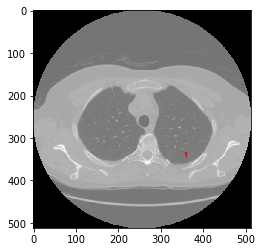

In [19]:
#path, xml_path = luna.get_random_path(training_data=True)
pic, anno, nod = luna.get_raw_data(path, xml_path)

size = pic.shape
three_c = np.zeros(shape=[size[0], size[1], 3])
for k in range(3):
    three_c[...,k] = pic
    
doc = 3
# set red chanel to 1 whenever in nodules and set all other channels to 0
for x in range(size[0]):
    for y in range(size[1]):
        if (nod[doc])[x,y]==1:
            three_c[x,y,0] = 1
            three_c[x,y,1] = 0
            three_c[x,y,2] = 0
    
three_c[...,0] = three_c[...,0] + nod[0]
plt.figure()
plt.imshow(three_c)
plt.show()